# Linear Regression - Top model according to the SCPM of -7.35	(dominance count 19)

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

# Feature importance
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_linreg_df_importances(scores):
    coefs = {}
    bias = {}
    coefs_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        coefs[index] = model.coef_.copy()
        bias[index] = model.intercept_.copy()

    for index, coefs_vec in coefs.items():
        coefs_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, coefs_vec)},
            index=[f"Coefficients - {index}"],
        )
        coefs_with_column.append(coefs_col)
    df_bias = pd.Series(bias)
    df_coefs = pd.concat(coefs_with_column)

    return df_coefs, df_bias

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "207",
    "Plant": "AT",
    "Features": "Chemical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/207/at.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [8]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

In [9]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

## 1.3. Time Series Cross Validation

In [10]:
repeats = 1
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("transformer", StandardScaler()),
        ("estimator", LinearRegression()),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 1
n_splits: 5

******
[TRAIN]
******
RMSE: -1.663 (0.179)
MAE: -1.290 (0.143)
MAPE: -0.028 (0.003)
R2: 0.544 (0.075)


******
[TEST]
******
RMSE: -1.913 (0.309)
MAE: -1.508 (0.226)
MAPE: -0.034 (0.004)
R2: 0.449 (0.348)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


for idx, pipeline in enumerate(scores["estimator"]):
    # index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    # index_preds = np.concatenate([index_train, index_test])
    index_preds = index_test

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    # df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [12]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
289,2021-06-28,48.099998,43.372737,TEST
290,2021-06-28,46.799999,45.091728,TEST
291,2021-06-29,49.599998,45.803566,TEST
292,2021-06-29,45.400002,44.776182,TEST
293,2021-06-30,48.200001,45.661915,TEST
...,...,...,...,...
1724,2023-09-22,47.799999,46.999337,TEST
1725,2023-09-23,47.799999,46.943081,TEST
1726,2023-09-23,44.299999,43.005484,TEST
1727,2023-09-25,44.299999,42.729706,TEST


<IPython.core.display.Javascript object>

In [13]:
# df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "S"
# for fold, (train_index, test_index) in enumerate(cv.split(x)):
#     df_copy_merge.loc[train_index, "FOLD"] = fold + 1
#     df_copy_merge.loc[test_index, "FOLD"] = fold + 1
# df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
# df_copy_merge.to_excel("local_model_linear_regression_btsscv_209_k.xlsx", index=False)
# df_copy_merge.to_csv("local_model_linear_regression_btsscv_209_k.csv", index=False)

<IPython.core.display.Javascript object>

In [14]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

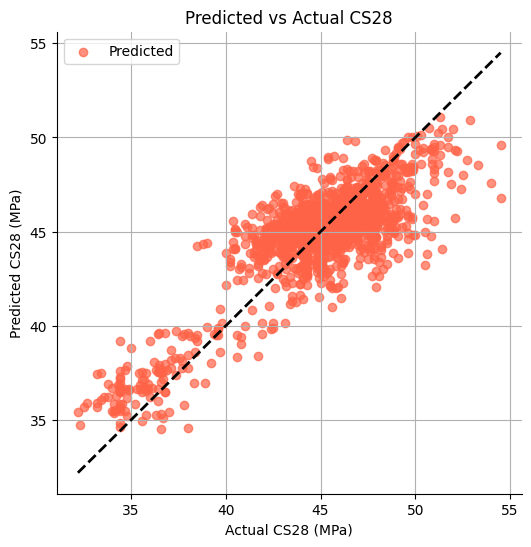

<IPython.core.display.Javascript object>

In [15]:
test_data = df_pred[df_pred["SET"] == "TEST"]

plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_207_at_local_cm_p_cs_tiss_top_scpm_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


In [16]:
df["Cement_Type"].value_counts()

Cement_Type
CPIII40    814
CPVARI     781
CPIIF32    134
Name: count, dtype: int64

<IPython.core.display.Javascript object>

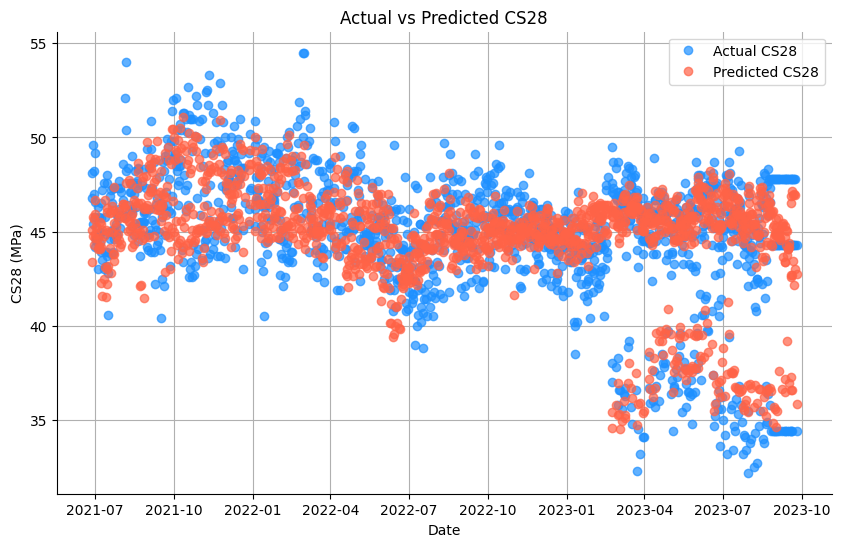

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_207_at_local_cm_p_cs_tiss_top_scpm_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [18]:
df_coefs, df_bias = get_linreg_df_importances(scores)
df_importances = df_coefs

<IPython.core.display.Javascript object>

In [19]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#200,#400,Specific Gravity,Initial setting time,Final setting time,CS3,CS7
Coefficients - 0,-0.533782,-0.059507,0.506554,-3.888391,3.099966,0.697804,-0.889427,0.588158,-0.371154,0.131612,0.241333,0.228028,-0.122545,-0.982725,0.466649,-0.026342,0.174418,2.100901
Coefficients - 1,-0.743914,0.109679,0.356264,-3.090981,2.750380,1.171178,-1.039573,0.703490,-0.325092,0.234058,0.154949,0.361809,-0.206626,-0.191434,0.398231,0.033255,-0.094201,2.064770
Coefficients - 2,-0.281992,-0.056898,0.387743,-2.801867,2.544349,0.834438,-0.647541,0.086301,-0.574209,0.044264,0.031860,0.456410,-0.275084,0.406981,0.686850,-0.299569,-0.700661,2.172349
Coefficients - 3,-0.412189,-0.185230,0.493717,-2.540230,2.730354,0.702122,-0.598506,0.089612,-0.410157,-0.036106,0.068219,0.394941,-0.201324,0.299598,0.703467,-0.314364,-0.147845,2.207070
Coefficients - 4,0.174067,-0.248170,0.682050,-2.249423,2.651705,0.642707,-0.627701,-0.452560,-0.741703,-0.076725,0.123781,0.371132,-0.200405,0.291889,0.580832,-0.270847,0.063978,2.207681


<IPython.core.display.Javascript object>

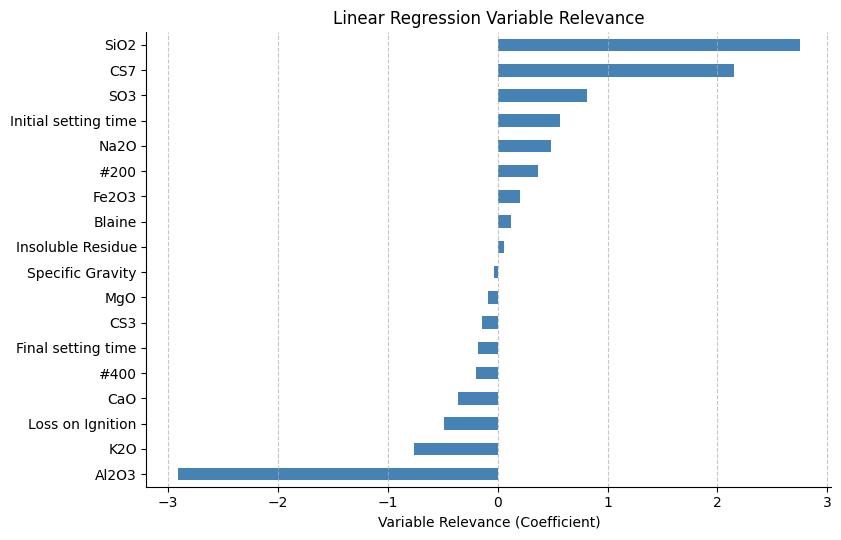

<IPython.core.display.Javascript object>

In [20]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Linear Regression Variable Relevance")
plt.xlabel("Variable Relevance (Coefficient)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

In [21]:
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

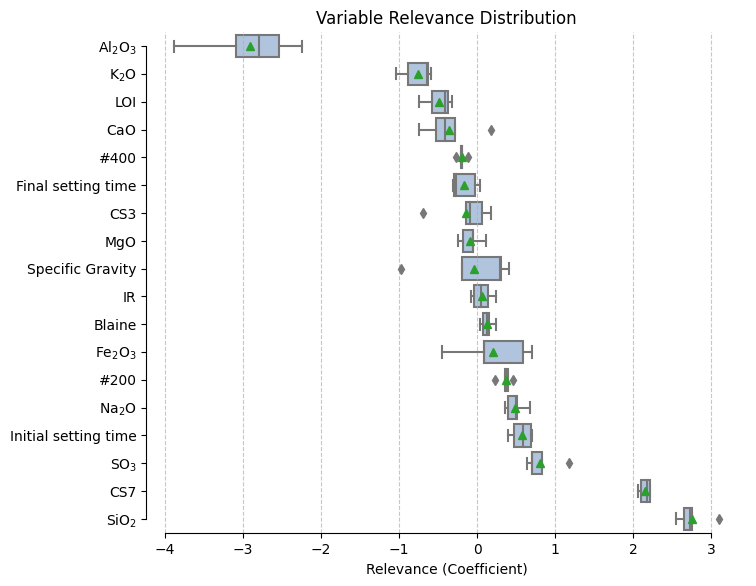

<IPython.core.display.Javascript object>

In [22]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 6.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Coefficient)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)

plt.savefig(
    "ecics_207_at_local_cm_p_cs_tiss_top_scpm_dist_var_coef_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [23]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#200,#400,Specific Gravity,Initial setting time,Final setting time,CS3,CS7
Coefficients - 0,-0.533782,-0.059507,0.506554,-3.888391,3.099966,0.697804,-0.889427,0.588158,-0.371154,0.131612,0.241333,0.228028,-0.122545,-0.982725,0.466649,-0.026342,0.174418,2.100901
Coefficients - 1,-0.743914,0.109679,0.356264,-3.090981,2.750380,1.171178,-1.039573,0.703490,-0.325092,0.234058,0.154949,0.361809,-0.206626,-0.191434,0.398231,0.033255,-0.094201,2.064770
Coefficients - 2,-0.281992,-0.056898,0.387743,-2.801867,2.544349,0.834438,-0.647541,0.086301,-0.574209,0.044264,0.031860,0.456410,-0.275084,0.406981,0.686850,-0.299569,-0.700661,2.172349
Coefficients - 3,-0.412189,-0.185230,0.493717,-2.540230,2.730354,0.702122,-0.598506,0.089612,-0.410157,-0.036106,0.068219,0.394941,-0.201324,0.299598,0.703467,-0.314364,-0.147845,2.207070
Coefficients - 4,0.174067,-0.248170,0.682050,-2.249423,2.651705,0.642707,-0.627701,-0.452560,-0.741703,-0.076725,0.123781,0.371132,-0.200405,0.291889,0.580832,-0.270847,0.063978,2.207681


<IPython.core.display.Javascript object>

In [24]:
df_importances.describe().T.sort_values(by=["mean"])

,count,mean,std,min,25%,50%,75%,max
Al2O3,5.0,-2.914178,0.627435,-3.888391,-3.090981,-2.801867,-2.540230,-2.249423
K2O,5.0,-0.760550,0.194385,-1.039573,-0.889427,-0.647541,-0.627701,-0.598506
Loss on Ignition,5.0,-0.484463,0.171746,-0.741703,-0.574209,-0.410157,-0.371154,-0.325092
CaO,5.0,-0.359562,0.343375,-0.743914,-0.533782,-0.412189,-0.281992,0.174067
#400,5.0,-0.201197,0.054027,-0.275084,-0.206626,-0.201324,-0.200405,-0.122545
Final setting time,5.0,-0.175573,0.165525,-0.314364,-0.299569,-0.270847,-0.026342,0.033255
CS3,5.0,-0.140862,0.337995,-0.700661,-0.147845,-0.094201,0.063978,0.174418
MgO,5.0,-0.088025,0.137808,-0.248170,-0.185230,-0.059507,-0.056898,0.109679
Specific Gravity,5.0,-0.035138,0.578103,-0.982725,-0.191434,0.291889,0.299598,0.406981
Insoluble Residue,5.0,0.059421,0.126096,-0.076725,-0.036106,0.044264,0.131612,0.234058


<IPython.core.display.Javascript object>

In [25]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [26]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    scaler = pipeline.named_steps["transformer"]
    # Compute MDI importance
    # mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        scaler.transform(imputer.transform(x.iloc[test_idx])),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        # scoring="neg_mean_squared_error",
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

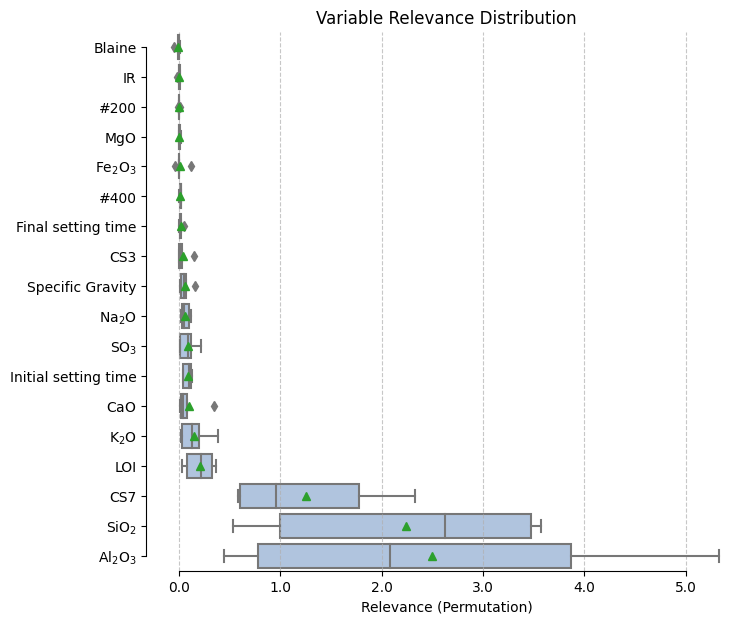

<IPython.core.display.Javascript object>

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Convert lists to DataFrames
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 7))

# Create boxplot
sns.boxplot(
    data=perm_importances_df_plot.round(2),
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)

# Set x-axis label and title
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")

# Add gridlines for x-axis
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Format x-axis to show 1 decimal place
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.1f}"))

# Adjust the layout to prevent label cut-off
plt.subplots_adjust(left=0.3)

# Save the plot
plt.savefig(
    "ecics_207_at_local_cm_p_cs_tiss_top_scpm_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# Show the plot
plt.show()

# Reset all rcParams to their default values
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [28]:
perm_importances_df.describe().round(4).T.sort_values(by="mean")

,count,mean,std,min,25%,50%,75%,max
Blaine,5.0,-0.0088,0.0248,-0.0523,-0.0058,0.0027,0.0036,0.0076
Insoluble Residue,5.0,0.0000,0.0103,-0.0161,-0.0029,0.0016,0.0071,0.0103
#200,5.0,0.0008,0.0055,-0.0059,-0.0015,-0.0004,0.0026,0.0091
MgO,5.0,0.0053,0.0086,-0.0044,-0.0012,0.0049,0.0101,0.0169
Fe2O3,5.0,0.0171,0.0580,-0.0397,0.0010,0.0041,0.0049,0.1153
#400,5.0,0.0176,0.0089,0.0048,0.0118,0.0217,0.0246,0.0249
Final setting time,5.0,0.0181,0.0199,-0.0006,0.0078,0.0127,0.0191,0.0513
CS3,5.0,0.0397,0.0651,-0.0005,0.0036,0.0093,0.0321,0.1538
Specific Gravity,5.0,0.0641,0.0614,0.0147,0.0160,0.0526,0.0726,0.1646
Na2O,5.0,0.0655,0.0447,0.0163,0.0340,0.0531,0.1040,0.1199


<IPython.core.display.Javascript object>

In [29]:
perm_importances_df

,Blaine,Insoluble Residue,#200,MgO,Fe2O3,#400,Final setting time,CS3,Specific Gravity,Na2O,SO3,Initial setting time,CaO,K2O,LOI,CS7,SiO2,Al2O3
0,0.007621,0.010300,-0.001513,-0.001247,0.115338,0.004826,-0.000573,0.009252,0.164642,0.053086,0.215587,0.100506,0.076461,0.125641,0.027486,1.778772,3.467474,5.328465
1,-0.052276,-0.016120,0.009078,0.004930,-0.039678,0.024604,0.007780,0.032111,0.052595,0.119880,0.119623,0.131975,0.351641,0.394410,0.217599,0.958553,3.574344,2.081552
2,0.003601,-0.002935,-0.000395,0.016864,0.004940,0.024907,0.051253,0.153828,0.072612,0.104045,0.085647,0.123393,0.035366,0.199899,0.078074,2.330334,2.627275,3.867745
3,0.002655,0.001642,0.002552,0.010133,0.001007,0.011847,0.019139,-0.000485,0.016043,0.034050,0.007955,0.043504,0.019002,0.034042,0.326167,0.600561,0.996534,0.781127
4,-0.005802,0.007126,-0.005879,-0.004367,0.004131,0.021656,0.012668,0.003597,0.014739,0.016267,0.009334,0.040558,0.009098,0.020179,0.370087,0.576043,0.526700,0.450513


<IPython.core.display.Javascript object>